# Introductory Tutorial: Fundamentals for pocket-coffea - Reconstructing the Z Boson

It's time to apply what we've learned! In this exercise, we will perform a classic particle physics analysis: we will search for the Z boson (Z) from its decay into two muons $(Z \ to \ \mu+\mu−)$.
Objective: Create pairs of muons, calculate their invariant mass, and visualize the Z boson peak in a histogram.

In [1]:
import uproot
import awkward as ak
import numpy as np
import hist 
import particle, hepunits
import matplotlib.pyplot as plt

### Step 1: Upload the relevant data

We already know how to open a file and access the TTree. But this time, we don't want all the branches (there could be hundreds).

Your task: Load only the branches we need for the muons: their transverse momentum (pt), eta, phi, and charge. Let's use the first 10,000 events to get good statistics.

Hint: The tree.arrays() method has a filter_name argument that accepts regular expressions (regex) to select branches by name.

The path of the root file is:
data/SMHiggsToZZTo4L.root

In [2]:
file = uproot.open("data/SMHiggsToZZTo4L.root")

tree = file["Events"]

#### Exploring the File Contents (Optional but Recommended)

Before loading the data, it is a good practice to explore what the file contains. uproot offers very useful methods for this.

First, we can use .classnames() on the file object to see all the top-level objects it contains and their type.

In [3]:
file.classnames()

{'Events;1': 'TTree'}

This shows us that there is an object called Events which is a TTree, the standard container for event data in ROOT format. This confirms that the next step is to access it with tree = file[‘Events’].

Once we have our TTree, we can use .show() to see a list of its variables, known as branches, and their data type.

In [4]:
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
run                  | int32_t                  | AsDtype('>i4')
luminosityBlock      | uint32_t                 | AsDtype('>u4')
event                | uint64_t                 | AsDtype('>u8')
PV_npvs              | int32_t                  | AsDtype('>i4')
PV_x                 | float                    | AsDtype('>f4')
PV_y                 | float                    | AsDtype('>f4')
PV_z                 | float                    | AsDtype('>f4')
nMuon                | uint32_t                 | AsDtype('>u4')
Muon_pt              | float[]                  | AsJagged(AsDtype('>f4'))
Muon_eta             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_phi             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_mass            | float[]                  | AsJagged(AsDtype('>f4'))
Muon_charge       

This command is very useful because it shows us the exact names of the branches we need for our analysis: Muon_pt, Muon_eta, Muon_phi, and Muon_charge.

Now that we know the names, we can confidently construct the correct filter to load only the data we are interested in.

### Step 2: Load Relevant Data

We already know how to open a file and access the TTree. But this time, we don't want all the branches (there could be hundreds). We need to be selective for our analysis to be efficient.

Your task:

Use the tree.arrays() method to load the data into a variable called arrays. Make sure you meet these two requirements:

* Load only the branches we need for the muons: their transverse momentum (pt), pseudorapidity (eta), azimuthal angle (phi), and their charge.

Hint: The tree.arrays() method has a filter_name argument that accepts regular expressions (regex). Use the branch names you discovered with tree.show() to build the correct filter.

In [5]:
arrays = tree.arrays(filter_name="/Muon_(pt|eta|phi|charge)/")

### Step 3: Structuring the Muon Data

Currently, we have our data in separate arrays (arrays[‘Muon_pt’], arrays[‘Muon_eta’], etc.). To work more comfortably and intuitively, it is better to group them to have a single list of “muons”, where each “muon” is an object with all its properties together (pt, eta, phi, charge).

Your task:

Use the ak.zip function to “compress” the separated arrays into a single array called muons.

Hint: ak.zip takes a dictionary where the keys are the new field names (such as “pt”) and the values are the corresponding data arrays (such as arrays[“Muon_pt”]).

In [6]:
muons = ak.zip(
    {
        "pt": arrays["Muon_pt"],
        "eta": arrays["Muon_eta"],
        "phi": arrays["Muon_phi"],
        "charge": arrays["Muon_charge"],
    }

)

#### Checking the Structure Change

To understand the fundamental difference we just made, we can inspect the .type attribute of our arrays before and after the operation. This is the difference between an “array structure” and an “array of structures”.

Before: We had a single “record” (struct) containing lists of properties.

In [7]:
arrays.type

299973 * {"Muon_pt": var * float32, "Muon_eta": var * float32, "Muon_phi": var * float32, "Muon_charge": var * int32}

After: Now we have a list of events, where each event contains a list of “muons”, and each muon is a record with its properties.

In [8]:
muons.type

299973 * var * {"pt": float32, "eta": float32, "phi": float32, "charge": int32}

### Step 4: Create muon pairs

The Z boson decays into two muons (Z $\rightarrow$ $\mu_1$ and $\mu_2$), so the next logical step is to form all possible combinations of two muons in each event. From these pairs, we can calculate the invariant mass and search for our candidate.

Once you have the pairs, “unzip” them into two separate arrays: $\mu_1$ and $\mu_2$.

Your task:

Complete the following two steps in the code cell:

1. Use the ak.combinations() function to generate all combinations of 2 muons from your muon array. Store the result in a variable called pairs.

2. To facilitate future calculations, “unzip” the pairs into two separate arrays: $\mu_1$ and $\mu_2$. The ak.unzip() function is perfect for this, as it will take each pair ($\mu_A$, $\mu_B$) and put all $\mu_A$ in the $\mu_1$ array and all $\mu_B$ in the $\mu_2$ array.

In [9]:
# 1. Create the muon pairs
pairs = ak.combinations(muons, 2)

# 2. Decompress the pairs into mu1 and mu2
mu1, mu2 = ak.unzip(pairs)

# Optional: Take a look at the type of ‘pairs’ to see the new structure
pairs.type

299973 * var * ({"pt": float32, "eta": float32, "phi": float32, "charge": int32}, {"pt": float32, "eta": float32, "phi": float32, "charge": int32})

Quick Check: 

Now we have two arrays, $\mu_1$ and $\mu_2$, containing the first and the second muon of each pair, respectively. Logically, both arrays should have exactly the same structure and number of elements per event. Let's check it quickly.

In [10]:
num_pairs_mu1_per_event = ak.num(mu1, axis=1)
num_pairs_mu2_per_event = ak.num(mu2, axis=1)
print(f"Number of pairs in $\mu_1$ per event (first 10): {num_pairs_mu1_per_event[:10]}")
print(f"Number of pairs in $\mu_2$ per event (first 10): {num_pairs_mu2_per_event[:10]}")

Number of pairs in $\mu_1$ per event (first 10): [3, 0, 0, 21, 0, 1, 0, 0, 0, 0]
Number of pairs in $\mu_2$ per event (first 10): [3, 0, 0, 21, 0, 1, 0, 0, 0, 0]


In [11]:
are_lengths_equal_per_event = (num_pairs_mu1_per_event == num_pairs_mu2_per_event)
print(f"Are the lengths the same for each event (first 10)?: {are_lengths_equal_per_event[:10]}")

Are the lengths the same for each event (first 10)?: [True, True, True, True, True, True, True, True, True, True]


In [12]:
all_lengths_are_equal = ak.all(are_lengths_equal_per_event)
print(f"\nAre ALL lengths equal in mu1 and mu2 for each event?: {all_lengths_are_equal}")


Are ALL lengths equal in mu1 and mu2 for each event?: True


In [13]:
print(f"Total number of elements in $\mu_1$: {ak.num(mu1, axis=1)}")
print(f"Total number of elements in $\mu_2$: {ak.num(mu2, axis=1)}")

Total number of elements in $\mu_1$: [3, 0, 0, 21, 0, 1, 0, 0, 0, 0, 0, 1, 0, ... 3, 0, 0, 0, 1, 1, 1, 0, 1, 1, 6, 0, 0]
Total number of elements in $\mu_2$: [3, 0, 0, 21, 0, 1, 0, 0, 0, 0, 0, 1, 0, ... 3, 0, 0, 0, 1, 1, 1, 0, 1, 1, 6, 0, 0]


As you can see, the lengths match perfectly. This structure is incredibly useful because we can now perform “vectorized” operations between the properties of the two muons of each pair. For example, to check if they have opposite charges, we can do mu1.charge != mu2.charge directly in the next step.

### Step 4: Calculate the Invariant Mass

Since they do have the same lengths, we will use the following formula to calculate the invariant mass of each pair of muons, assuming that their mass is negligible compared to their energy:

$\sqrt{2 * p_{T1} * p_{T2} \ (cosh(\eta_1 - \eta_2) - cos(\phi_1 - \phi_2))}$

Task: Apply this formula to your arrays $\mu_1$ and $\mu_2$.

Hint: Thanks to the “magic” of Awkward and NumPy, you can use NumPy functions (np.sqrt, np.cosh, np.cos) directly on arrays. The operation will be applied to each pair of muons automatically (this is called vectorization).

In [14]:
mass = np.sqrt(
    2 * mu1.pt * mu2.pt * (np.cosh(mu1.eta - mu2.eta) - np.cos(mu1.phi - mu2.phi))
)

### Step 5: The first histogram

Now we have an array mass containing the invariant mass of each pair of muons in each event. To see if we have found something, we need to visualize the distribution of all these masses. The perfect tool for this is a histogram.

If the Z boson is in our data, we should see an accumulation of events (a “bump”) around its known mass.

Task: Create a histogram of all the masses you calculated. Use the hist library and chain the methods in a single line to achieve this:

* Create the object with hist.Hist(), defining a regular axis (hist.axis.Regular) with 120 bins in a range from 0 to 120 GeV.

* Fill the histogram with the mass data using the .fill() method.

* Plot the result with the .plot() method.

Key Hint: The .fill() method needs a flat (1D) array, but our mass array has a nested structure (a list of masses for each event). Use ak.ravel(mass) to “flatten” your array before passing it to .fill().

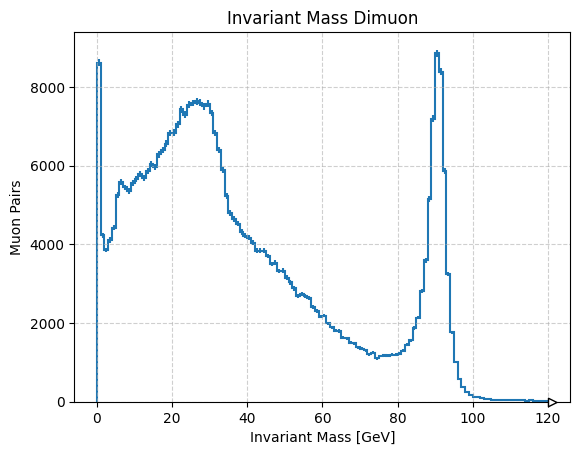

In [15]:
hist.Hist(
    hist.axis.Regular(120, 0, 120, label="Invariant Mass [GeV]")
).fill(ak.ravel(mass)).plot()


plt.ylabel("Muon Pairs")
plt.title("Invariant Mass Dimuon")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

We start to see a peak around 90 GeV. That is the signal from our Z boson. However, there is also a lot of background noise from other processes. In the next step, we will apply cuts to clean up this signal and make our peak much clearer.

Note: Handling Empty Lists and None Values

In the previous step, we used ak.ravel to flatten all the masses into a single list for the histogram. But what if you wanted to do a different operation, such as finding the maximum invariant mass at each event?

This is where awkward-array really shines when handling data with variable structure.

Problem: The Maximum of an Empty List

If we try to calculate the maximum in our array mass along the axis of pairs (axis=1), we run into an interesting detail. Some events do not have any valid muon pairs (after our cuts), so their mass list is empty.

In [16]:
ak.max(mass, axis=1)

<Array [89.5, None, None, ... 2.93, None, None] type='299973 * ?float32'>

The output of this command will contain None values for those events, because the maximum of an empty list is not defined. awkward uses None as a placeholder for these missing values.


Two Solutions for a Clean Result:

To get a final list with only the maximum values (and no None), awkward offers two ways to think about the problem:

1. compute and Then Clean:

We can first compute the maximum and then use ak.flatten (or ak.ravel) to remove None values from the resulting list.

In [17]:
ak.flatten(ak.max(mass, axis=1), axis=None)

<Array [89.5, 98.7, 87.1, ... 27.9, 90.5, 2.93] type='145597 * float32'>

2. Clean and Then Calculate (More Efficient):
An often clearer and more efficient approach is to first filter out the events we are not interested in (those with empty mass lists) and then perform the calculation.

In [18]:
# 1. We filter to keep only events that have at least one pair
non_empty_mass = mass[ak.num(mass) > 0]

# 2. Now we calculate the maximum. As there are no empty lists, no Nones will be generated.
ak.max(non_empty_mass, axis=1)

<Array [89.5, 98.7, 87.1, ... 27.9, 90.5, 2.93] type='145597 * ?float32'>

Both methods give the same end result. This flexibility to handle “irregular” or missing data is one of the most powerful features of awkward-array.

### Step 6: Applying cuts

Our first histogram shows a promising signal, but it is contaminated by a lot of background noise. We will now apply two “cuts” based on the physics of the process to refine our event selection and obtain a much sharper Z boson peak.

Hints: Opposite Charge Cut The Z boson (electrically neutral), so it must decay into oppositely charged muons ($\mu+\mu−$).

Filter out the pairs to keep only those where mu1.charge is different from mu2.charge.

Task: Create a boolean mask called cut that is True only for pairs where the charge of mu1 is different from that of mu2.

Apply this mask to your mass array when filling the histogram. The syntax in awkward is very straightforward: mass[cut].

Create a new histogram with the filtered masses, you should see a big improvement.

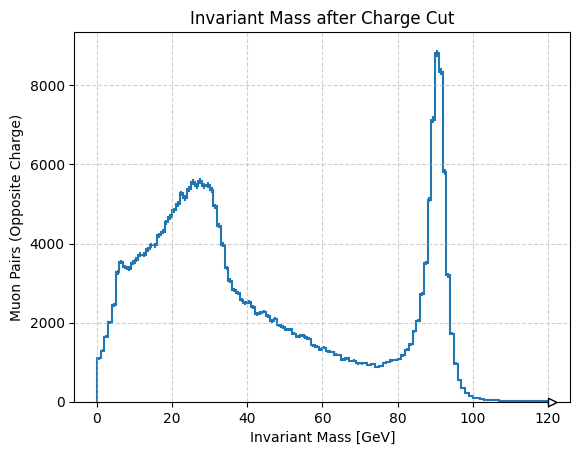

In [19]:
# 1. Create the opposite load cut mask
cut = (mu1.charge != mu2.charge)

# 2. Creates the histogram by applying the cut to the masses
hist.Hist(
 hist.axis.Regular(120, 0, 120, label="Invariant Mass [GeV]")
).fill(ak.ravel(mass[cut])).plot()

# Style
plt.ylabel("Muon Pairs (Opposite Charge)")
plt.title("Invariant Mass after Charge Cut")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Much better. The background noise has decreased.


Task 2: Selection of the "Best" Candidate Pair

In some events, there may be more than one pair ($\mu+\mu−$) valid. To obtain the sharpest possible peak, a common technique is to stick with only the pair whose invariant mass is closest to the known Z mass (~91.2 GeV).

Task:

* Use ak.argmin() to find, for each event, the index of the pair whose mass has the minimum absolute difference with the mass of Z.

* Use these indices to select only the “best” mass of each event.

* Create the final histogram with this ultra-clean data - this will be your final result!

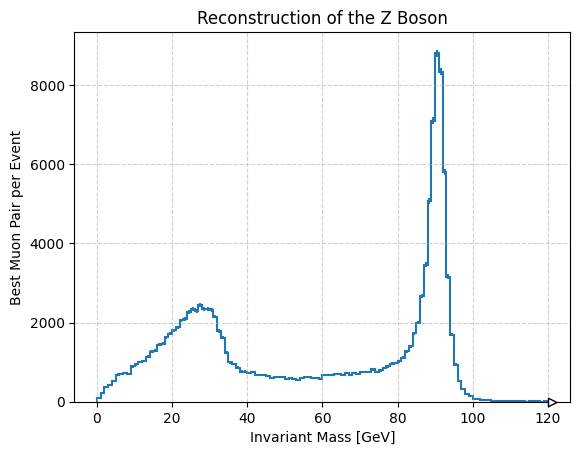

In [20]:
zmass = particle.Particle.findall("Z0")[0].mass / hepunits.GeV

# 1. The charge cut is applied and the index of the pair closest in mass to Z is found
which = ak.argmin(abs(mass[cut] - zmass), axis=1, keepdims=True)

# 2. The index is used to select only the best mass of each event
histogram_data = ak.ravel(mass[cut][which])

# Remove None values resulting from events without pairs
histogram_data_cleaned = histogram_data[~ak.is_none(histogram_data)]

# 4. The final histogram is created
hist.Hist(
 hist.axis.Regular(120, 0, 120, label="Invariant Mass [GeV]")
).fill(histogram_data_cleaned).plot()

# Style
plt.ylabel("Best Muon Pair per Event")
plt.title("Reconstruction of the Z Boson")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

The numerous events at lower masses (below ~70 GeV) are considered background. These are muon pairs produced by physical processes other than the decay of a Z boson. A key challenge is to distinguish a rare signal from a large amount of background. The clear appearance of the Z peak above this background indicates a correct measurement.

Smaller bumps at very low masses could correspond to the reconstruction of other lighter particles that also decay into muon pairs, such as the $J/\psi$ meson (~3.1 GeV) and the Upsilon (Υ) family of mesons ($~9.5$ GeV).